#📊 Clustering Stocks Using EWMA Correlation

_A time-weighted correlation analysis and unsupervised grouping of financial assets_

**Author:** Nicholas Taylor
**Date:** 2025-06

## 📌 Project Overview

This project explores the use of **Exponentially Weighted Moving Averages (EWMA)** to measure and visualize the evolving correlations between publicly traded stocks. Using this dynamic correlation structure, we:
- Identify tightly correlated groups of stocks
- Compare these groups against traditional industry classifications
- Analyze whether group dynamics can help in forecasting

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import csv
import time
import random
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

## 1️⃣ Data Collection

We download historical stock price data from Yahoo Finance for a diverse set of ~200 global tickers, covering a wide range of sectors.


In [17]:
ticker_list = ['KO', 'MDB', 'BAC', 'BLK', 'SYK', 'MRK', 'AAL', 'PINS', 'LOW', 'DAL', 'SHW', 'LLY', 'ASML', 'UNH', 'PSX', 'CRM', 'HSY', 'AFRM', 'CHTR', 'PCAR', 'DECK', 'SPGI', 'RHHBY', 'SHOP', 'WFC', 'CVX', 'ABBV', 'BMY', 'AEP', 'PYPL', 'JNJ', 'AXP', 'NVS', 'YUM', 'MSCI', 'ECL', 'MDLZ', 'HCA', 'SBUX', 'UAL', 'CHD', 'KMI', 'XOM', 'CVS', 'GILD', 'HLT', 'QSR', 'LHX', 'GOOGL', 'SLB', 'DDOG', 'VWAGY', 'EQNR', 'AMD', 'VALE', 'COST', 'AMAT', 'GE', 'WMT', 'NVDA', 'NOW', 'TCEHY', 'D', 'COP', 'JD', 'ELV', 'IQV', 'CBOE', 'RIO', 'SAP', 'SCHW', 'LYV', 'TDOC', 'NEE', 'SO', 'ROST', 'MKC', 'STLD', 'CRWD', 'MS', 'DVN', 'PCG', 'HON', 'APD', 'GS', 'REGN', 'KHC', 'INFY', 'BIDU', 'SRE', 'TTE', 'CSCO', 'NET', 'CMCSA', 'ADDYY', 'MAR', 'NFLX', 'SNOW', 'CZR', 'APA', 'GM', 'SNAP', 'NDAQ', 'META', 'NUE', 'EW', 'VLO', 'VRTX', 'HES', 'AZN', 'MSFT', 'BA', 'ADBE', 'SPOT', 'V', 'BHP', 'CCL', 'BSX', 'NTES', 'BKNG', 'TSLA', 'LMT', 'ZS', 'K', 'F', 'TJX', 'SKX', 'T', 'SEDG', 'BEP', 'SPWR', 'DOW', 'NOC', 'IBM', 'UL', 'BYD', 'LCID', 'TM', 'ETN', 'LVMUY', 'MCD', 'WYNN', 'CLX', 'C', 'PENN', 'DUK', 'FI', 'BABA', 'WBD', 'AMGN', 'ENPH', 'ADSK', 'EL', 'AVGO', 'RCL', 'MA', 'DG', 'SHEL', 'LIN', 'X', 'QCOM', 'TMO', 'PEG', 'MPC', 'OXY', 'EMR', 'DD', 'FCX', 'HD', 'CL', 'RTX', 'PPG', 'GPN', 'MDT', 'INTU', 'GD', 'FANG', 'ETSY', 'AAPL', 'WMB', 'PM', 'ROKU', 'INTC', 'ZBH', 'TSM', 'CAT', 'PFE', 'LRCX', 'VZ', 'RIVN', 'MGM', 'ACN', 'DOV', 'HRL', 'CMI', 'MU', 'KLAC', 'PARA', 'DPZ', 'KMB', 'PLTR', 'DE', 'ICE', 'BP', 'AMZN', 'DLTR', 'AA', 'PG', 'FSLR', 'ABNB', 'OKTA', 'GIS', 'TDG', 'EIX', 'UBER', 'DOCU', 'EXC', 'DIS', 'UAA', 'TGT', 'WIT', 'ISRG', 'ED', 'HAL', 'PEP', 'WDAY', 'RUN', 'EPAM', 'BKR', 'LYFT', 'TMUS', 'PDD', 'NKE', 'ORCL', 'NEM', 'JPM', 'LULU', 'PANW', 'MO', 'EOG', 'FTNT', 'MRNA', 'IR', 'CME', 'ULTA', 'LYB', 'EQIX']



In [18]:
#list dates to map for
start_date = "2020-01-01"
end_date = "2025-06-12"
#end_date=dt.now().strftime("%Y-%m-%d")

# --- EWMA Configuration ---
# 'span' determines the decay. A smaller span means faster decay and more weight to recent data.
# Common values: 20 (approx. 1 month), 60 (approx. 3 months).
ewma_span = 720 # You can adjust this value based on how much you want to prioritize recent data

In [19]:
def get_tickers_data(ticker_list, start_date, end_date):
    """
    Download ticker data for a list of tickers.

    Args:
        ticker_list: List of ticker symbols
        start_date: Start date for data download
        end_date: End date for data download

    Returns:
        dict: Dictionary with ticker symbols as keys and dataframes as values
    """
    all_dict = {}

    for ticker in ticker_list:
        try:
            ticker_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)

            if ticker_data.empty:
                print(f"No data for ticker {ticker}")
                continue  # Skip this ticker

            all_dict[ticker] = ticker_data

        except Exception as e:
            print(f"Error downloading {ticker}: {e}")

    return all_dict

In [37]:
def plot_tickers(all_dict, figsize=(30, 10)):
    """
    Plot the closing prices for all tickers.

    Args:
        all_dict: Dictionary with ticker data (from get_tickers_data function)
        figsize: Tuple for figure size (width, height)
    """
    plt.figure(figsize=figsize)

    for ticker, ticker_data in all_dict.items():
        plt.plot(ticker_data.index, ticker_data['Close'], label=f"Close_{ticker}")

    plt.grid(True)
    plt.show()

In [21]:
all_dict=get_tickers_data(ticker_list, start_date, end_date)


1 Failed download:
['REGN']: Timeout('Failed to perform, curl: (28) Connection timed out after 10009 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


No data for ticker REGN


HTTP Error 404: 

1 Failed download:
['2B77']: YFTzMissingError('possibly delisted; no timezone found')


No data for ticker 2B77


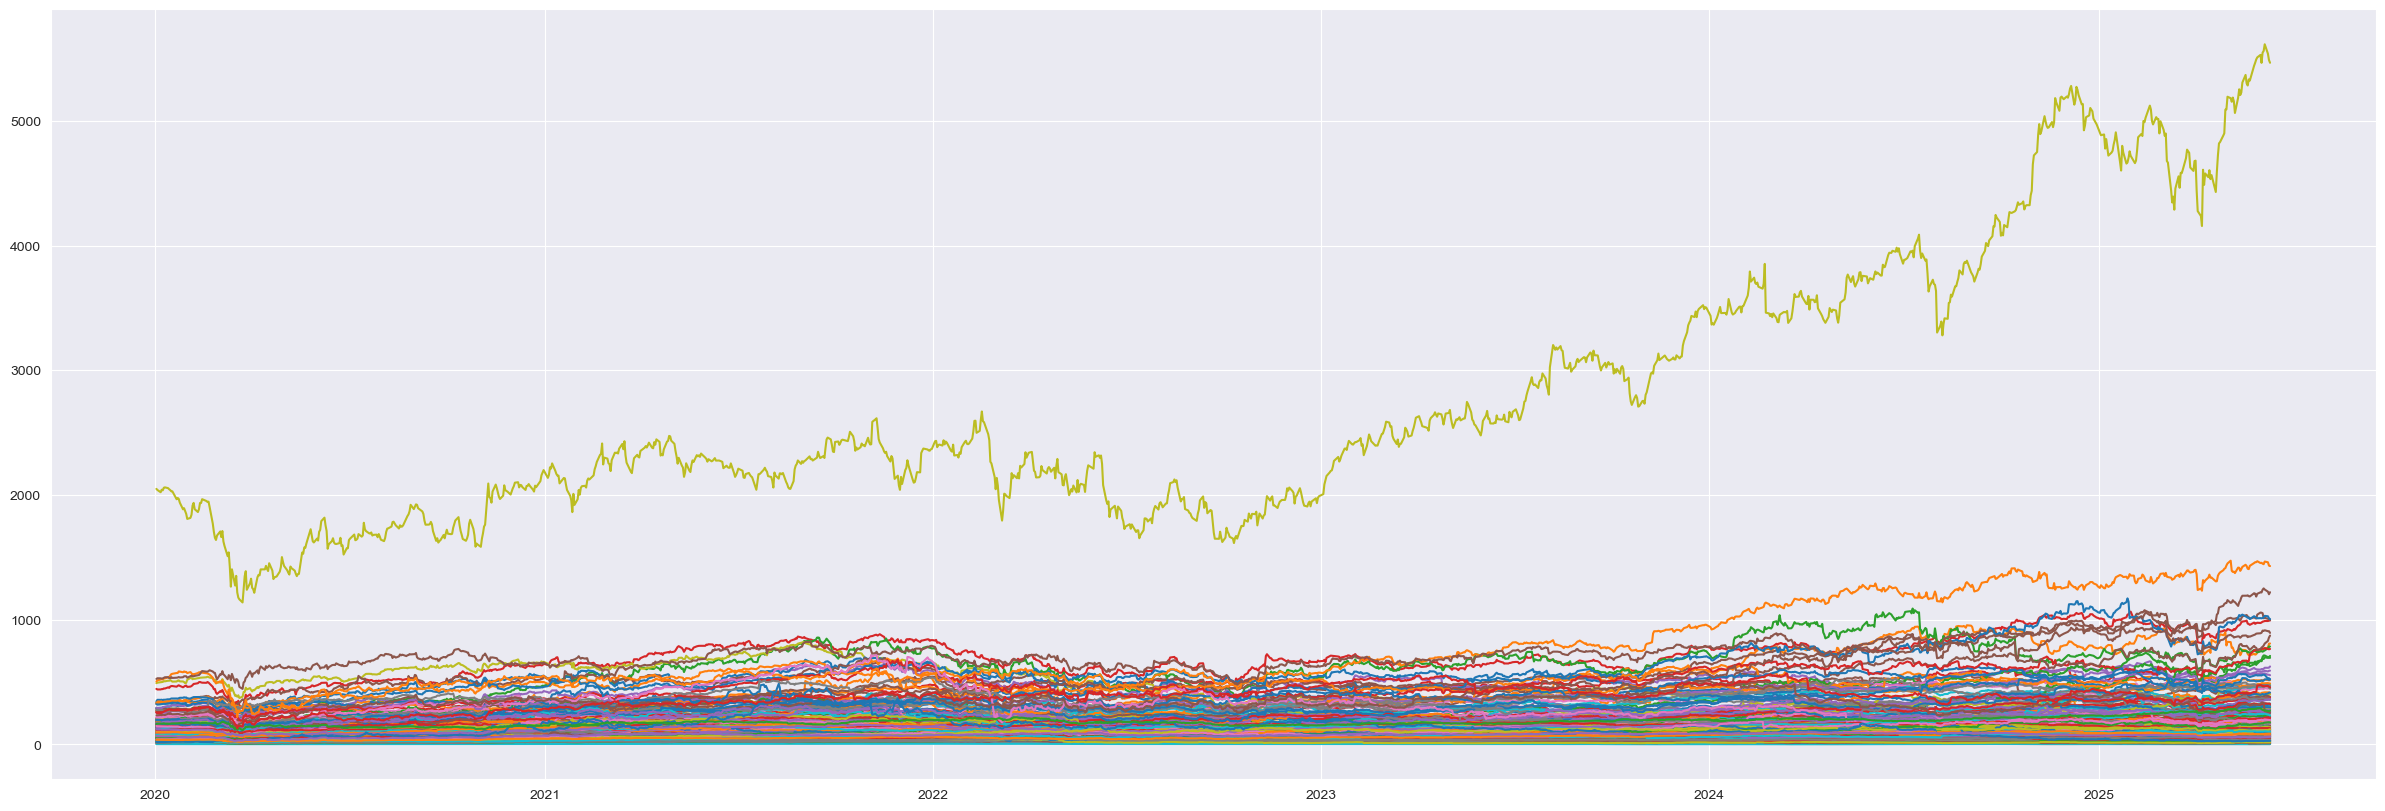

334125  total values


In [43]:
plot_tickers(all_dict)
total_subvalues = sum(len(values) for values in all_dict.values())

print(total_subvalues," total values")

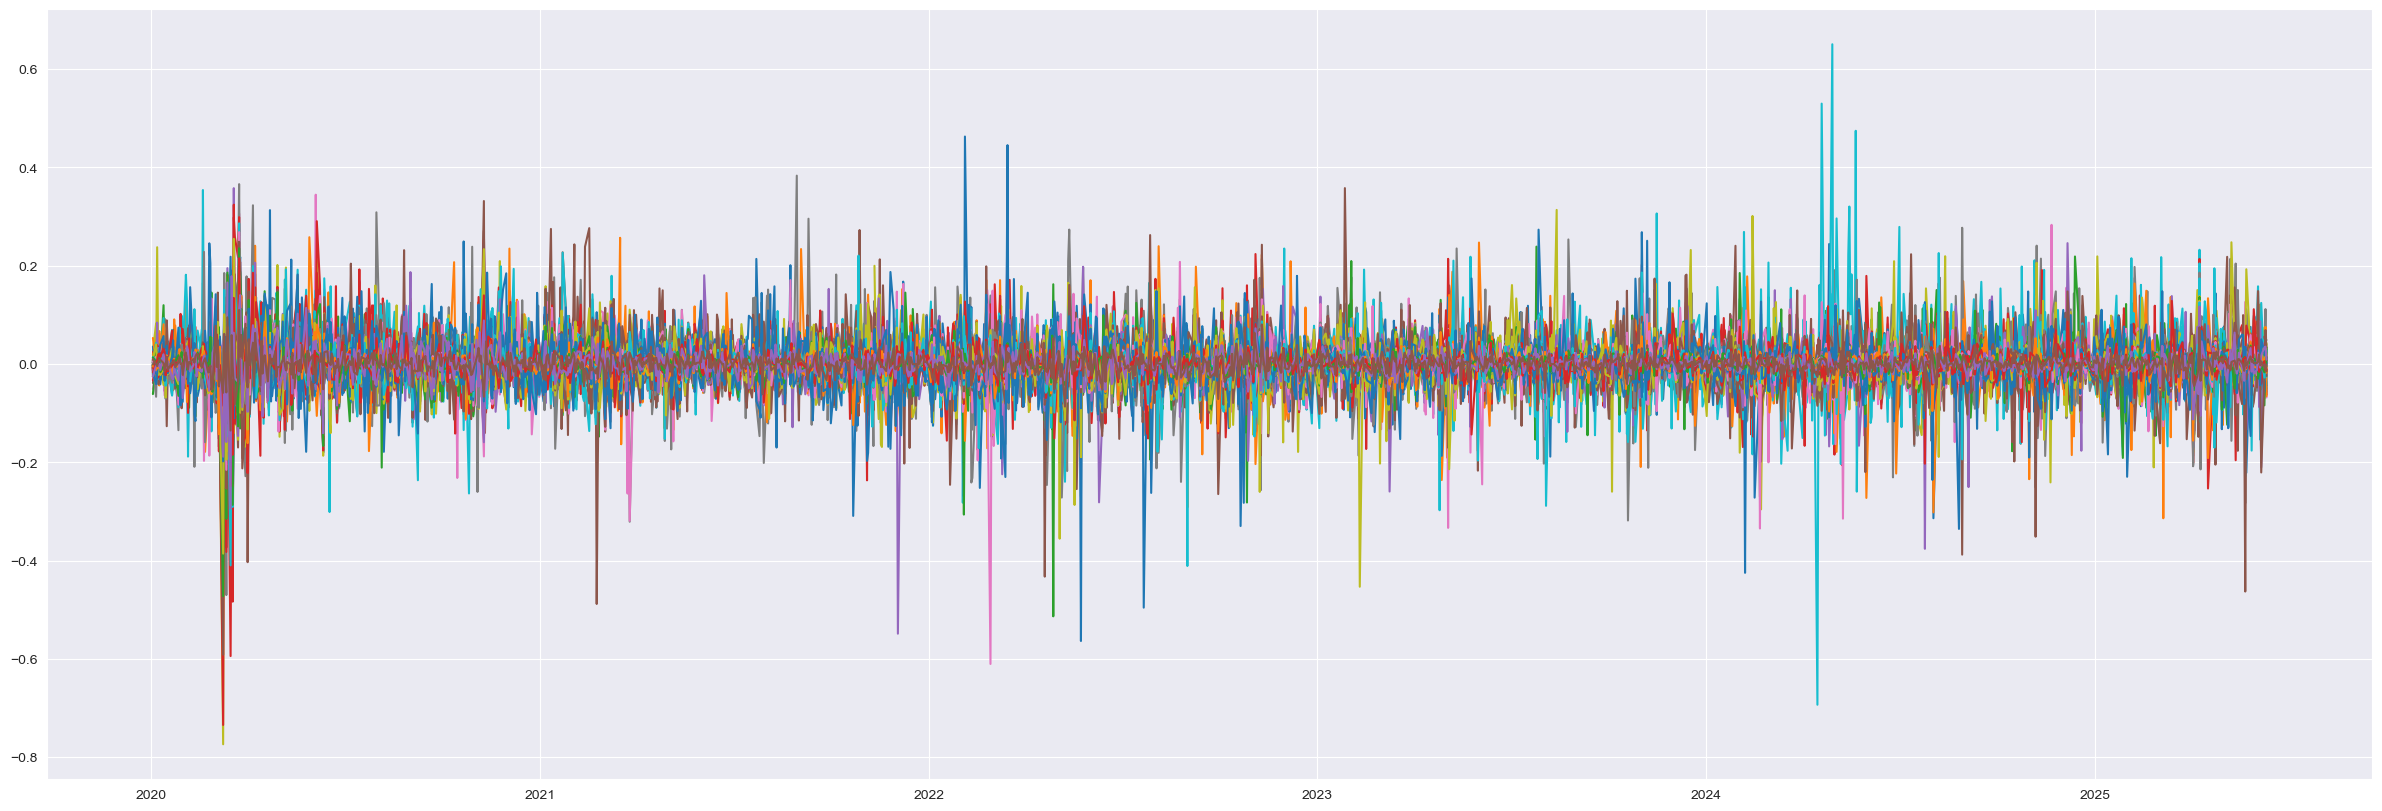

In [45]:
plt.figure(figsize=(30,10))

returns_list = []
for name in all_dict:
    returns = np.log(all_dict[name]['Close'] / all_dict[name]['Close'].shift(1))
    plt.plot(returns, label=name)
    returns.name = name  # name the series so we can concat later
    returns_list.append(returns)

# Build dataframe all at once
df_returns = pd.concat(returns_list, axis=1)

plt.grid(True)
plt.show()
plt.show()

In [24]:
# --- Calculate Exponentially Weighted Moving Average (EWMA) Correlation Matrix ---
# This gives more weight to recent values.
# The `span` parameter determines the decay rate.
# .corr() on the EWM object computes the EWMA correlation matrix.
# We then take the last complete correlation matrix from the multi-indexed result.
ewma_corr_df = df_returns.ewm(span=ewma_span).corr()

# Get the most recent EWMA correlation matrix
# df_returns.index[-1] gets the last date in your returns DataFrame.
correlation_matrix = ewma_corr_df.xs(df_returns.index[-1], level=0)

# Round the values for display purposes
correlation_matrix = round(correlation_matrix, 5)

#print correlation matrix
#print(correlation_matrix)

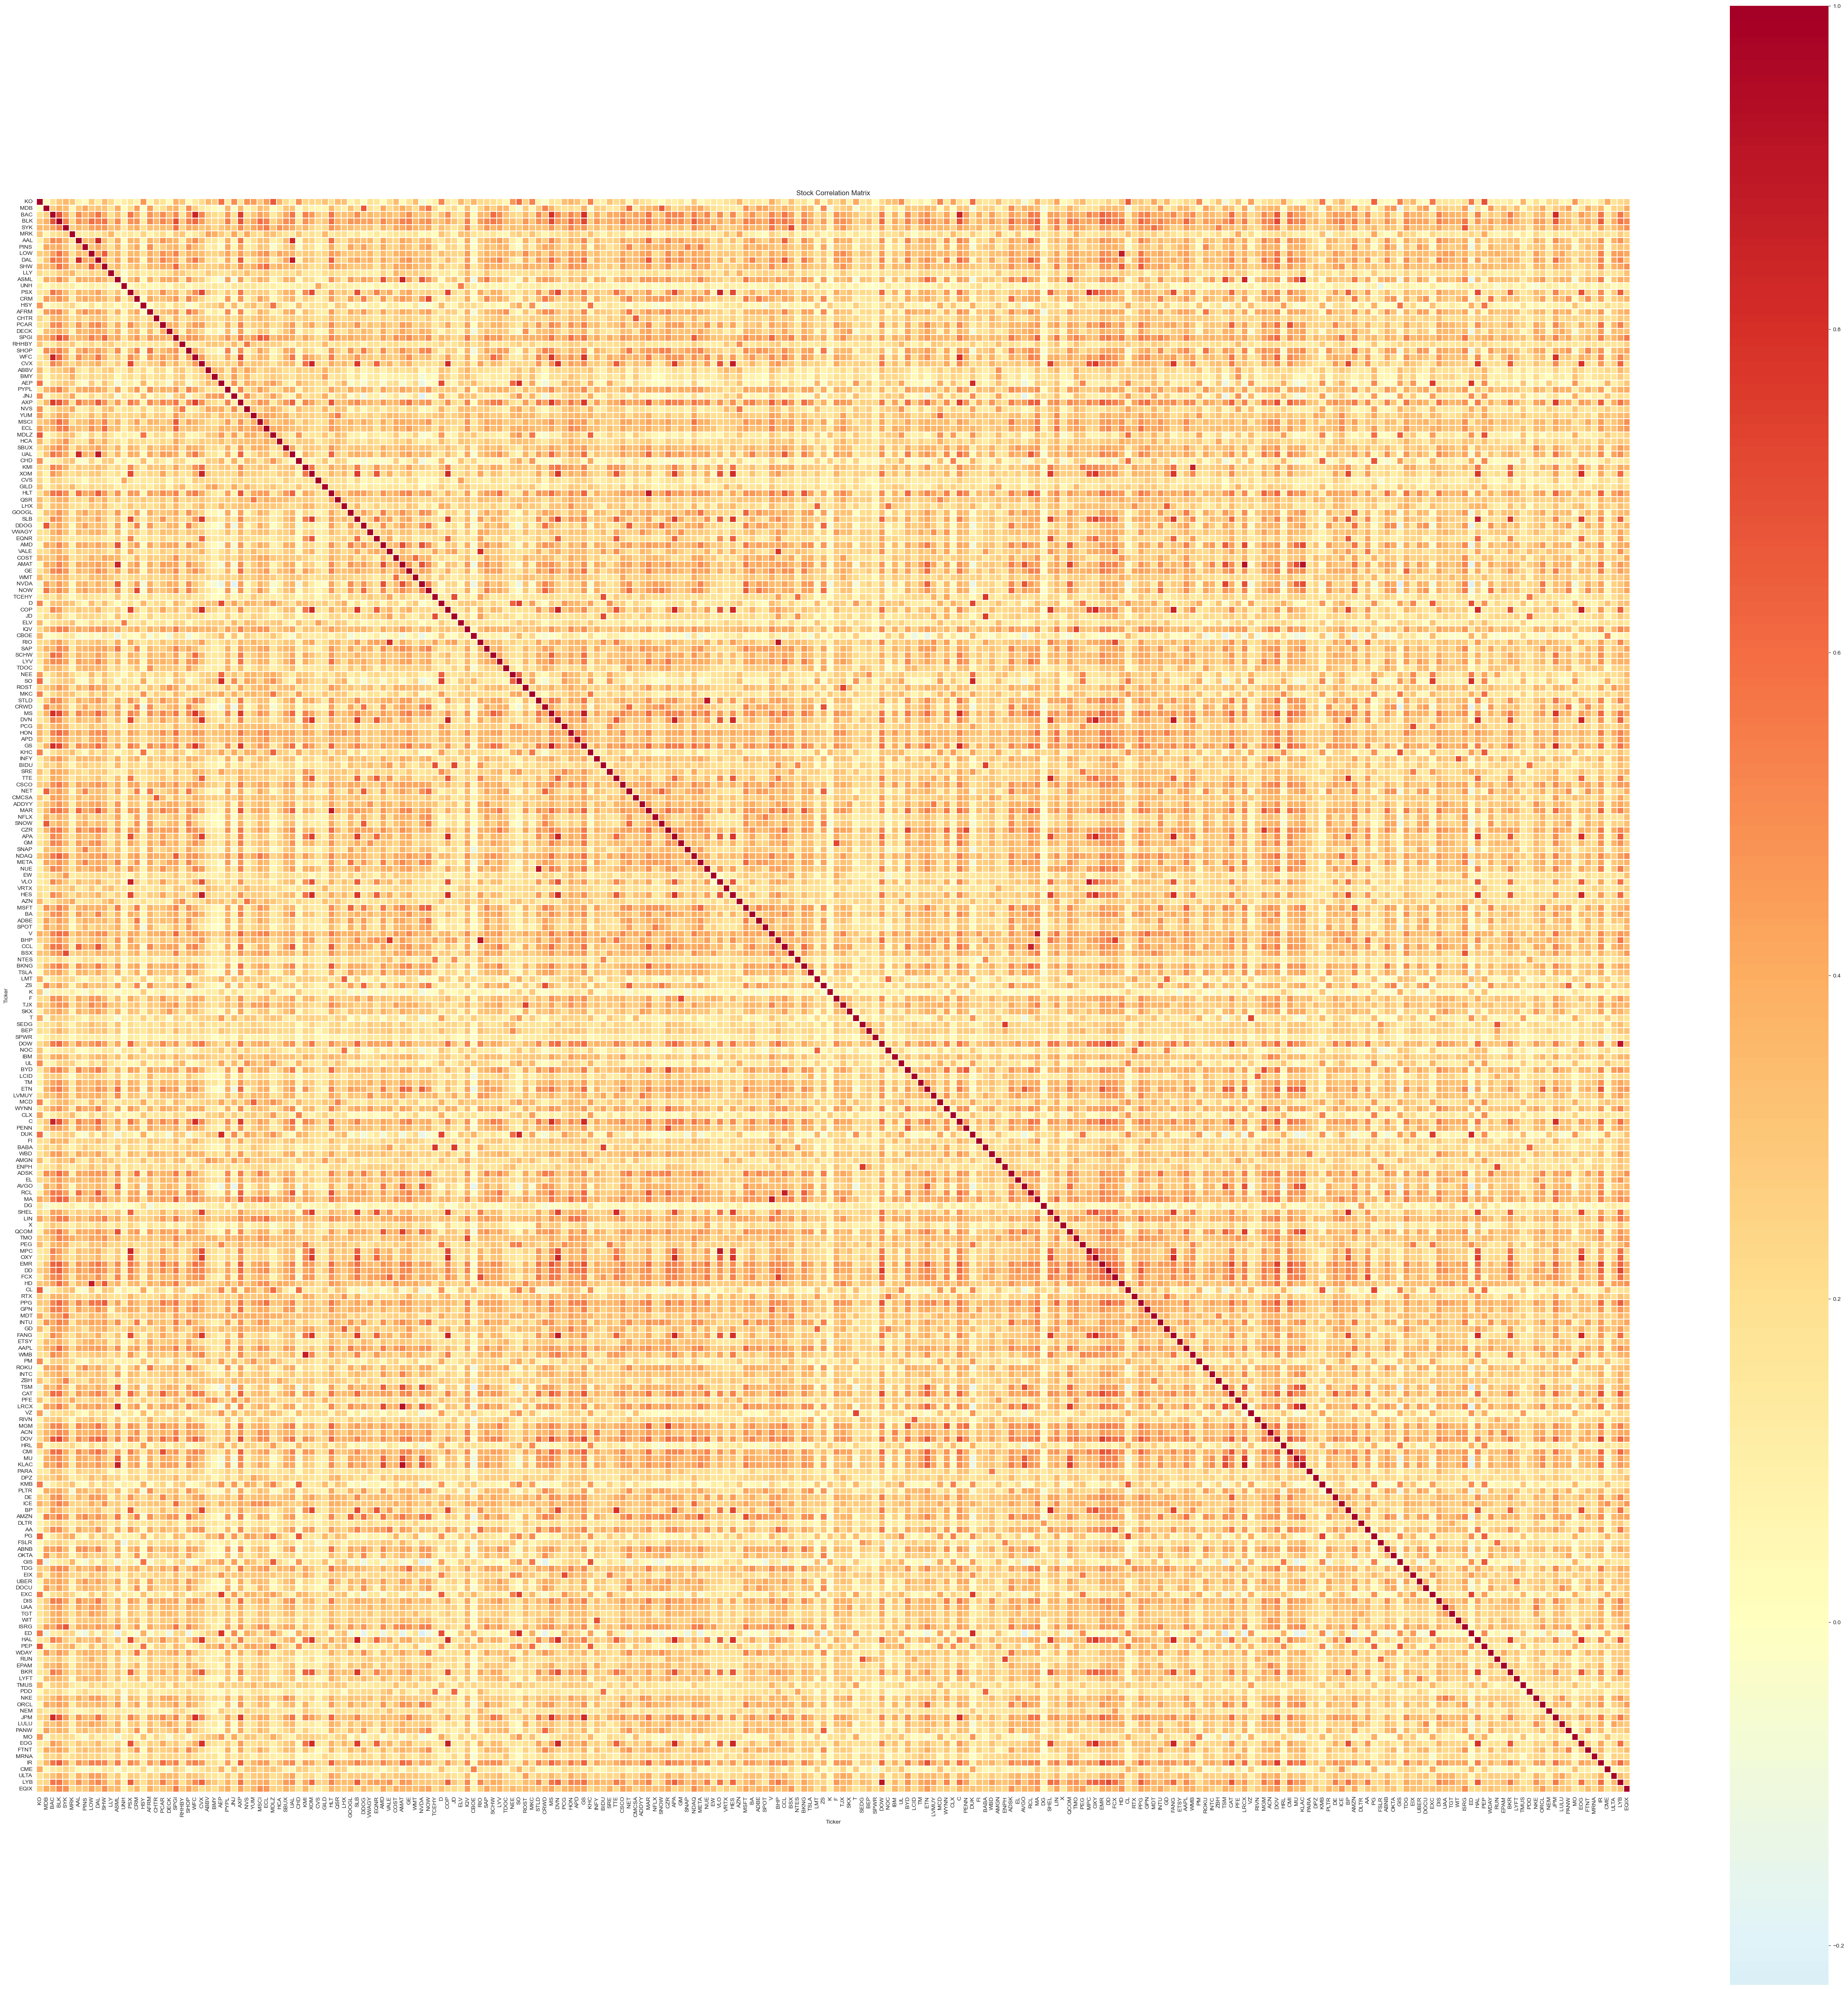

In [25]:
plt.figure(figsize=(round(len(correlation_matrix)/4), round(len(correlation_matrix)/4)))
sns.heatmap(correlation_matrix, annot=False,cmap='RdYlBu_r', center=0, square=True, linewidths=0.1)
plt.title('Stock Correlation Matrix')
plt.show()

In [26]:
# Start simple - find the "core" groups first
min_corr = 0.85
groups = []

# For each stock, see if it fits into an existing group
for stock in correlation_matrix.columns:
    placed = False

    # Check if this stock belongs to any existing group
    for group in groups:
        # If this stock correlates well with ANY stock already in the group
        #could implement a better clustering algorithim
        if any(correlation_matrix.loc[stock, existing_stock] >= min_corr
               for existing_stock in group if existing_stock != stock):
            group.append(stock)
            placed = True
            break

    # If it doesn't fit anywhere, start a new group
    if not placed:
        groups.append([stock])

# Clean up - only keep groups with more than 1 stock
final_groups = [group for group in groups if len(group) > 2]

print(final_groups)

[['ASML', 'AMAT', 'LRCX', 'KLAC'], ['PSX', 'VLO', 'MPC'], ['COP', 'DVN', 'APA', 'FANG', 'EOG']]


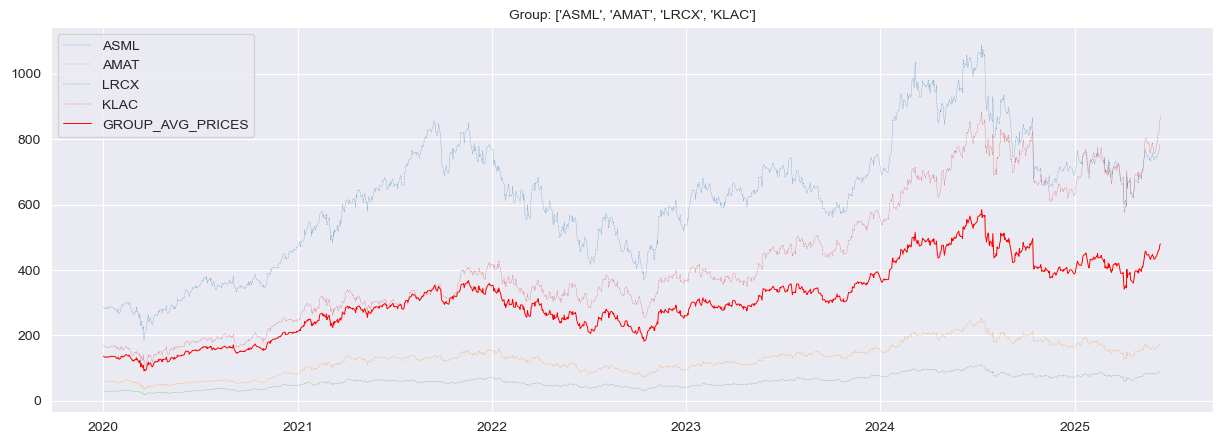

KLAC vs GROUP_EWM_AVG (excluding KLAC): 0.944,  KLA Corporation
LRCX vs GROUP_EWM_AVG (excluding LRCX): 0.993,  Lam Research Corporation
AMAT vs GROUP_EWM_AVG (excluding AMAT): 0.998,  Applied Materials, Inc.
ASML vs GROUP_EWM_AVG (excluding ASML): 0.950,  ASML Holding N.V.

intergroup correlation:0.88449


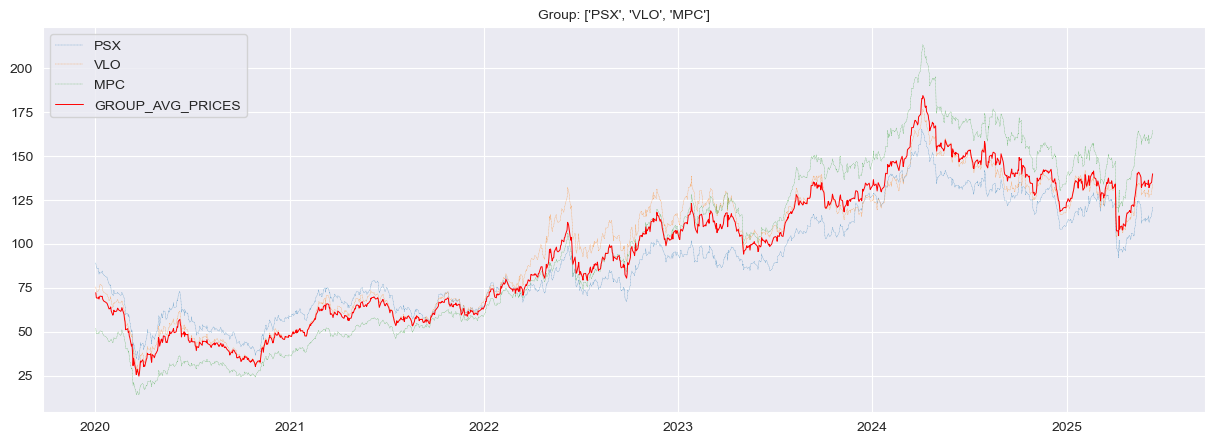

MPC vs GROUP_EWM_AVG (excluding MPC): 0.993,  Marathon Petroleum Corporation
VLO vs GROUP_EWM_AVG (excluding VLO): 0.991,  Valero Energy Corporation
PSX vs GROUP_EWM_AVG (excluding PSX): 0.979,  Phillips 66

intergroup correlation:0.86991


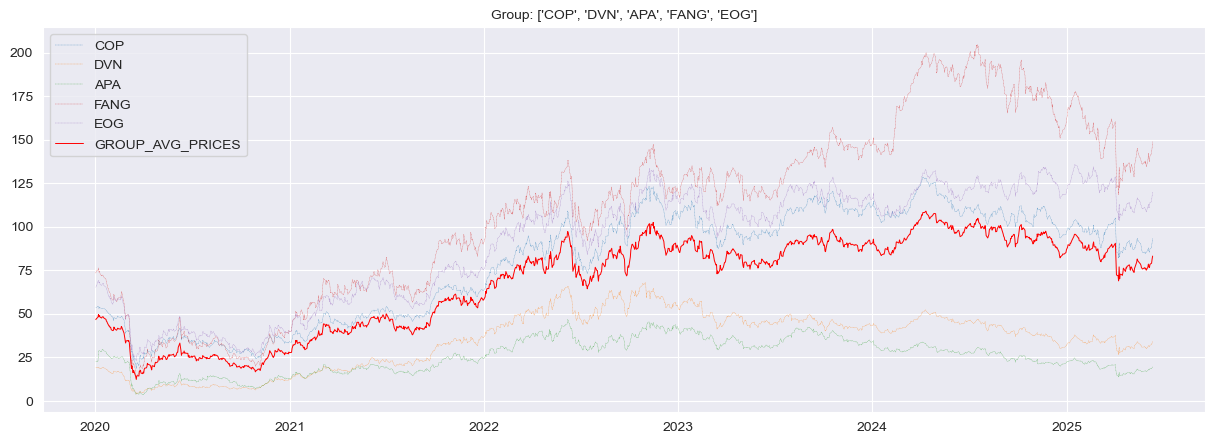

EOG vs GROUP_EWM_AVG (excluding EOG): 0.999,  EOG Resources, Inc.
FANG vs GROUP_EWM_AVG (excluding FANG): 0.978,  Diamondback Energy, Inc.
APA vs GROUP_EWM_AVG (excluding APA): 0.933,  APA Corporation
DVN vs GROUP_EWM_AVG (excluding DVN): 0.957,  Devon Energy Corporation
COP vs GROUP_EWM_AVG (excluding COP): 0.997,  ConocoPhillips

intergroup correlation:0.84388


In [63]:
for group in final_groups:
    plt.figure(figsize=(15, 5))  # Create a new figure for each group

    # Step 1: Get closing prices for all stocks in this group
    group_closes = pd.DataFrame()
    for stock in group:
        group_closes[stock] = all_dict[stock]['Close']
        plt.plot(group_closes[stock], label=stock, linestyle='dashed', linewidth=0.2)

    # Step 2: Calculate daily average across all stock prices
    group_avg_prices = group_closes.mean(axis=1)

    # Step 3: Plot the average prices
    plt.plot(group_avg_prices, label='GROUP_AVG_PRICES', linewidth=0.7, color='red')

    # Step 4: Make it look nice
    plt.title(f'Group: {group}',size=10)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Calculate correlation using EWM smoothed prices
    print_stats = ""
    for stock in group:
        # Apply EWM to individual stock prices first
        stock_ewm = group_closes[stock].ewm(span=ewma_span).mean()

        # Create group EWM average excluding the current stock
        other_stocks = [s for s in group if s != stock]
        other_prices_ewm = group_closes[other_stocks].ewm(span=ewma_span).mean()
        group_avg_excluding_stock = other_prices_ewm.mean(axis=1)

        # Correlate EWM-smoothed stock prices with EWM-smoothed group average
        corr_with_avg = stock_ewm.corr(group_avg_excluding_stock)
        print_stats = (f"{stock} vs GROUP_EWM_AVG (excluding {stock}): {corr_with_avg:.3f},  "
                       f"{yf.Ticker(stock).info['longName']}\n{print_stats}")

    print(print_stats)

    group_corr_matrix = correlation_matrix.loc[group, group]
    # Get upper triangle (avoid counting each pair twice)
    avg_corr = group_corr_matrix.where(np.triu(np.ones_like(group_corr_matrix, dtype=bool), k=1)).stack().mean()
    print(f"intergroup correlation:{avg_corr:.5f}")

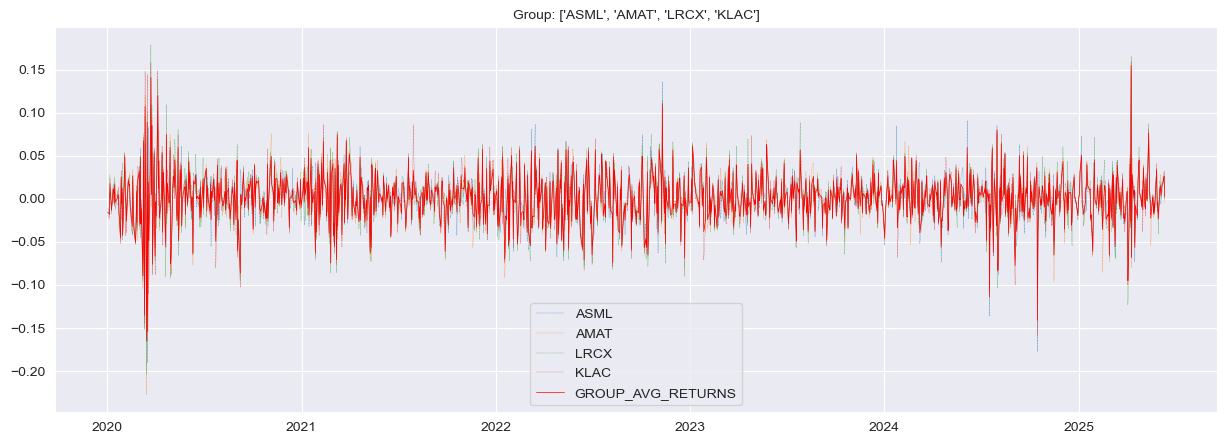

KLAC vs GROUP_EWM_AVG (excluding KLAC): 0.837,  KLA Corporation
LRCX vs GROUP_EWM_AVG (excluding LRCX): 0.880,  Lam Research Corporation
AMAT vs GROUP_EWM_AVG (excluding AMAT): 0.957,  Applied Materials, Inc.
ASML vs GROUP_EWM_AVG (excluding ASML): 0.900,  ASML Holding N.V.

intergroup correlation:0.88449


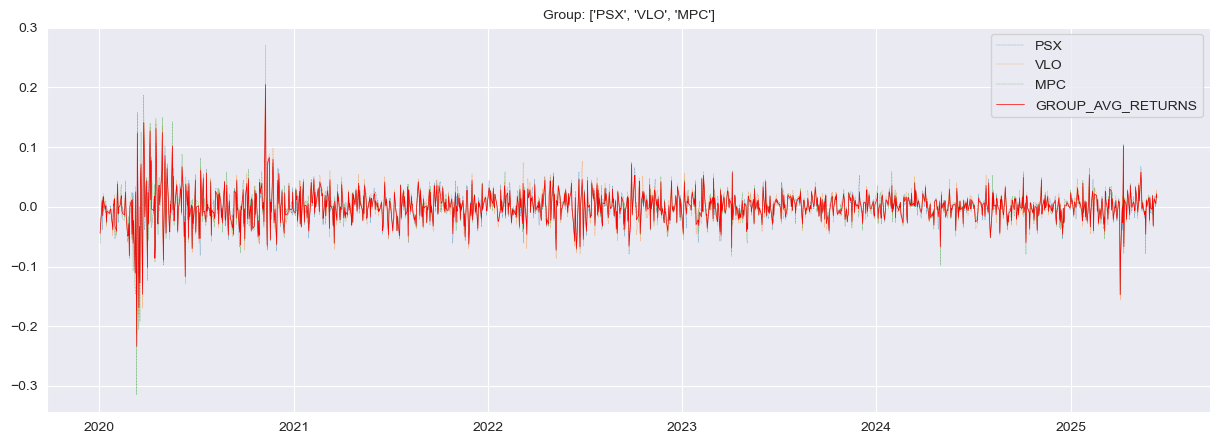

MPC vs GROUP_EWM_AVG (excluding MPC): 0.969,  Marathon Petroleum Corporation
VLO vs GROUP_EWM_AVG (excluding VLO): 0.973,  Valero Energy Corporation
PSX vs GROUP_EWM_AVG (excluding PSX): 0.955,  Phillips 66

intergroup correlation:0.86991


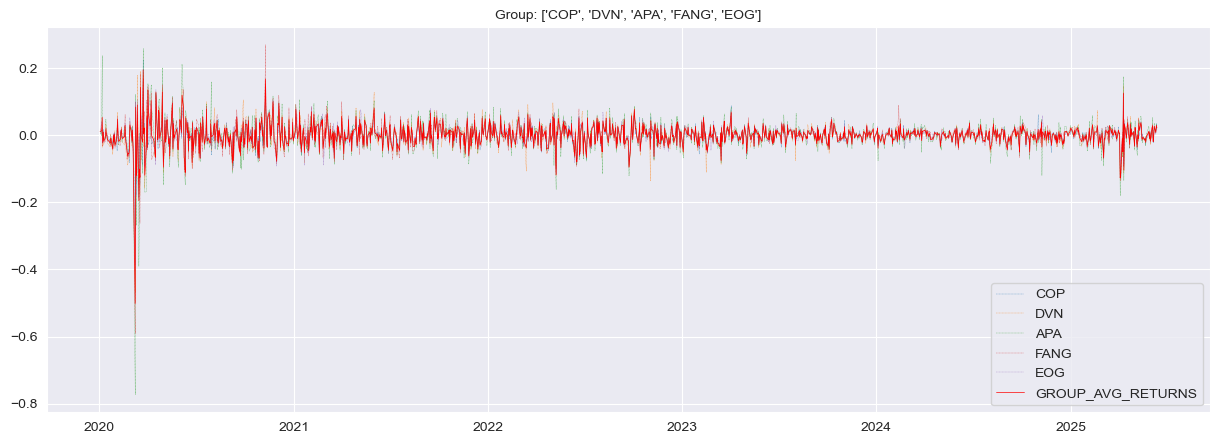

EOG vs GROUP_EWM_AVG (excluding EOG): 0.971,  EOG Resources, Inc.
FANG vs GROUP_EWM_AVG (excluding FANG): 0.935,  Diamondback Energy, Inc.
APA vs GROUP_EWM_AVG (excluding APA): 0.702,  APA Corporation
DVN vs GROUP_EWM_AVG (excluding DVN): 0.934,  Devon Energy Corporation
COP vs GROUP_EWM_AVG (excluding COP): 0.944,  ConocoPhillips

intergroup correlation:0.84388


In [64]:

for group in final_groups:
    plt.figure(figsize=(15, 5))  # Create a new figure for each group

    # Step 1: Get returns for all stocks in this group
    group_returns = pd.DataFrame()
    for stock in group:
        group_returns[stock] = df_returns[stock]
        plt.plot(group_returns[stock], label=stock, linestyle='dashed', linewidth=0.2)

    # Step 2: Calculate daily average across all stock returns
    group_avg_returns = group_returns.mean(axis=1)

    # Step 3: Plot the average returns
    plt.plot(group_avg_returns, label='GROUP_AVG_RETURNS', linewidth=0.5, color='red')

    # Step 4: Make it look nice
    plt.title(f'Group: {group}',size=10)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


    # Calculate correlation using EWM smoothed returns
    print_stats = ""
    for stock in group:
        # Apply EWM to individual stock returns first
        stock_ewm = group_returns[stock].ewm(span=ewma_span).mean()

        # Create group EWM average excluding the current stock
        other_stocks = [s for s in group if s != stock]
        other_returns_ewm = group_returns[other_stocks].ewm(span=ewma_span).mean()
        group_avg_excluding_stock = other_returns_ewm.mean(axis=1)

        # Correlate EWM-smoothed stock returns with EWM-smoothed group average
        corr_with_avg = stock_ewm.corr(group_avg_excluding_stock)
        print_stats = (f"{stock} vs GROUP_EWM_AVG (excluding {stock}): {corr_with_avg:.3f},  "
                       f"{yf.Ticker(stock).info['longName']}\n{print_stats}")

    print(print_stats)

    group_corr_matrix = correlation_matrix.loc[group, group]
    # Get upper triangle (avoid counting each pair twice)
    avg_corr = group_corr_matrix.where(np.triu(np.ones_like(group_corr_matrix, dtype=bool), k=1)).stack().mean()
    print(f"intergroup correlation:{avg_corr:.5f}")